In [1]:
from utils import *
from plotting import create_plot

In [ ]:
top5_same = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.0035_1%I_top5_with_0s_only_matching.tsv", sep='\t')
top5_same.rename(columns={'CosineHungarian_0.0035_0.0_1.0_scores': 'scores'}, inplace=True)
top5_same.rename(columns={'CosineHungarian_0.0035_0.0_1.0_matches': 'matches'}, inplace=True)
merged_top5_same = normalize_df(append_classes(top5_same, 'query'), matches_norm_col=None)

merged_top5_same_N = merged_top5_same.copy()

# exclude nitrigen
merged_top5_same = merged_top5_same[merged_top5_same['N'] != True]

# Apply the function to each row of the DataFrame
merged_top5_same_N['true_names'] = merged_top5_same_N.apply(lambda row: get_true_names(row, merged_top5_same_N), axis=1)
merged_top5_same['true_names'] = merged_top5_same.apply(lambda row: get_true_names(row, merged_top5_same), axis=1)

# Convert the list of names to a comma-separated string
merged_top5_same_N['true_names'] = merged_top5_same_N['true_names'].apply(lambda lst: ', '.join(lst))
merged_top5_same['true_names'] = merged_top5_same['true_names'].apply(lambda lst: ', '.join(lst))

In [ ]:
mdf = preprocess_data(merged_top5_same, ["true_names"])
mdf_N = preprocess_data(merged_top5_same_N, ["true_names"])

In [ ]:
mdf = clean_chemical_composition_data(mdf)
mdf_N = clean_chemical_composition_data(mdf_N)

In [ ]:
# with Nitrogen plot 1
mdf_N_p1 = split_and_add_rows(mdf_N, 'true_names', split_by=', ')
mdf_N_p1 = mdf_N_p1.sort_values(by=['true_names'])

create_plot(mdf_N_p1, "true_names", None, normalized_matches=False, hide_labels=True, showlegend=False).show()

# without Nitrogen plot 1
mdf_p1 = split_and_add_rows(mdf, 'true_names', split_by=', ')
mdf_p1 = mdf_p1.sort_values(by=['true_names'])
mdf_p1['true_names'].replace(to_replace="C,O,N,H", value="C,O,H", inplace=True)

create_plot(mdf_p1, "true_names", None, normalized_matches=False, hide_labels=True, showlegend=False).show()

In [ ]:
# without Nitrogen plot 2
mdf_p2 = generate_combinations(mdf, 'true_names')
mdf_p2 = mdf_p2.sort_values(by=['true_names'])

create_plot(mdf_p2, "true_names", None, normalized_matches=None, nist_scale=True, hide_labels=True, showlegend=False).show()

# with Nitrogen plot 2
mdf_N_p2 = generate_combinations(mdf_N, 'true_names')
mdf_N_p2 = mdf_N_p2.sort_values(by=['true_names'])

create_plot(mdf_N_p2, "true_names", None, normalized_matches=None, nist_scale=True, hide_labels=True, showlegend=False).show()

In [2]:

all_same = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.0035_1%I_all_peaks_with_0s_only_matching.tsv", sep='\t')
all_same.rename(columns={'CosineHungarian_0.0035_0.0_1.0_scores': 'scores'}, inplace=True)
all_same.rename(columns={'CosineHungarian_0.0035_0.0_1.0_matches': 'matches'}, inplace=True)
merged_all_same = normalize_df(append_spectrum_metadata(append_classes(all_same, 'query')))

merged_all_same_N = merged_all_same.copy()

# exclude nitrigen
merged_all_same = merged_all_same[merged_all_same['N'] != True]

# Apply the function to each row of the DataFrame
merged_all_same_N['true_names'] = merged_all_same_N.apply(lambda row: get_true_names(row, merged_all_same_N), axis=1)
merged_all_same['true_names'] = merged_all_same.apply(lambda row: get_true_names(row, merged_all_same), axis=1)

# Convert the list of names to a comma-separated string
merged_all_same_N['true_names'] = merged_all_same_N['true_names'].apply(lambda lst: ', '.join(lst))
merged_all_same['true_names'] = merged_all_same['true_names'].apply(lambda lst: ', '.join(lst))

In [ ]:
mdf_all = preprocess_data(merged_all_same, ["true_names"])
mdf_N_all = preprocess_data(merged_all_same_N, ["true_names"])
mdf_all = clean_chemical_composition_data(mdf_all)
mdf_N_all = clean_chemical_composition_data(mdf_N_all)

In [ ]:
# with Nitrogen plot 1
mdf_N_p1_all = split_and_add_rows(mdf_N_all, 'true_names', split_by=', ')
mdf_N_p1_all = mdf_N_p1_all.sort_values(by=['true_names'])

create_plot(mdf_N_p1_all, "true_names", None, showlegend=False, hide_labels=True).show()

# without Nitrogen plot 1
mdf_p1_all = split_and_add_rows(mdf_all, 'true_names', split_by=', ')
mdf_p1_all = mdf_p1_all.sort_values(by=['true_names'])
mdf_p1_all['true_names'].replace(to_replace="C,O,N,H", value="C,O,H", inplace=True)

create_plot(mdf_p1_all, "true_names", None, showlegend=False, hide_labels=True).show()

In [ ]:
# without Nitrogen plot 2
mdf_p2_all = generate_combinations(mdf_all, 'true_names')
mdf_p2_all = mdf_p2_all.sort_values(by=['true_names'])

create_plot(mdf_p2_all, "true_names", None, showlegend=False, hide_labels=True).show()

# with Nitrogen plot 2
mdf_N_p2_all = generate_combinations(mdf_N_all, 'true_names')
mdf_N_p2_all = mdf_N_p2_all.sort_values(by=['true_names'])

create_plot(mdf_N_p2_all, "true_names", None, showlegend=False, hide_labels=True).show()

In [2]:
all_peaks_same = pd.read_csv("../data/output_matching/matchms/matchms_tol_0.0035_1%I_all_peaks_with_0s_only_matching.tsv", sep='\t')
all_peaks_same.rename(columns={'CosineHungarian_0.0035_0.0_1.0_scores': 'scores'}, inplace=True)
all_peaks_same.rename(columns={'CosineHungarian_0.0035_0.0_1.0_matches': 'matches'}, inplace=True)
all_peaks_same = append_spectrum_metadata(all_peaks_same)
merged_all_peaks_same = normalize_df(append_classes(all_peaks_same, 'query'))
mdf_comp = preprocess_data(merged_all_peaks_same, ["composition"])

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:233: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha='right')


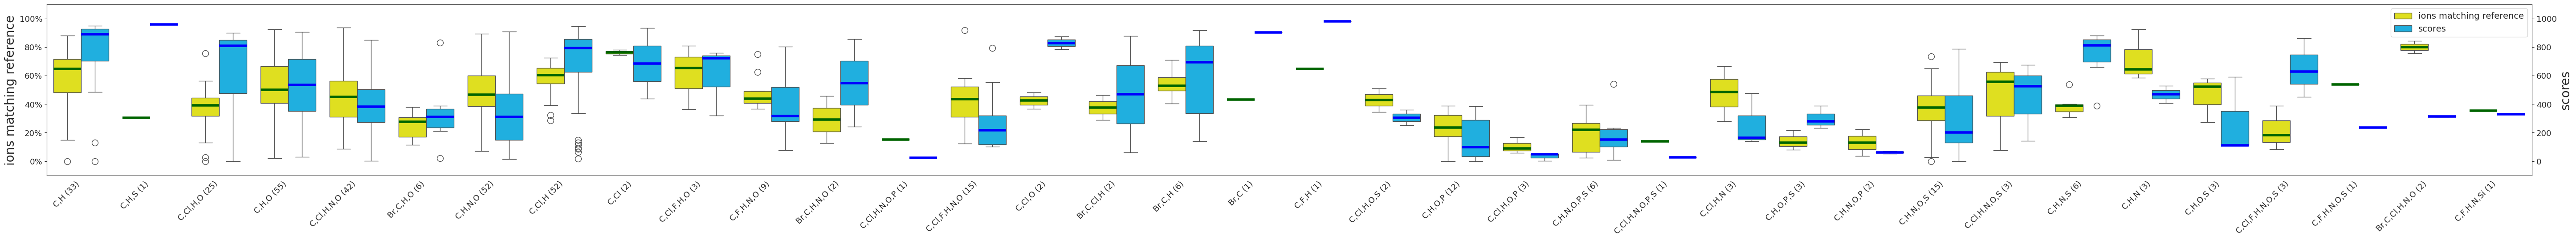

In [3]:
create_plot(mdf_comp, "composition").show()

/tmp/ipykernel_16745/164016082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf_comp_baseline.sort_index(axis=1, inplace=True)
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:233: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha='right')


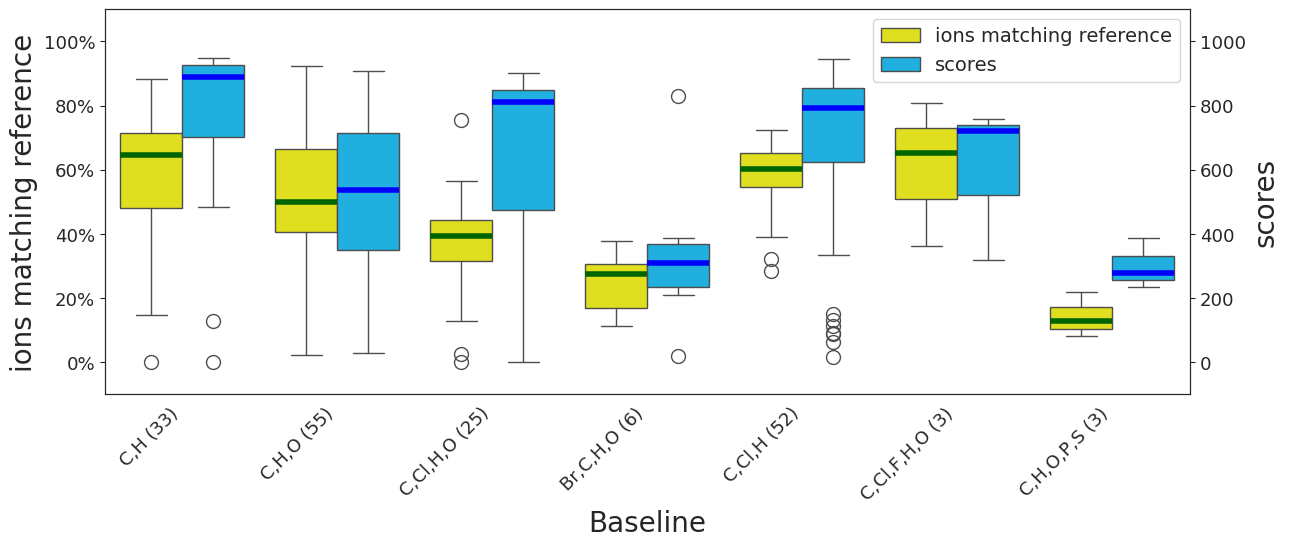

In [6]:
baseline_cols= ['C,H', 'C,H,O', 'C,Cl,H,O', 'Br,C,H,O', 'C,Cl,H', 'C,Cl,F,H,O', 'C,H,O,P,S']
mdf_comp_baseline = mdf_comp.loc[mdf_comp['composition'].isin(baseline_cols)]
mdf_comp_baseline.sort_index(axis=1, inplace=True)
create_plot(mdf_comp_baseline, "composition", "Baseline", order=baseline_cols).show()


/tmp/ipykernel_16745/3707899431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf_comp_nitrogen.sort_index(axis=1, inplace=True)
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(f"{int(x)}%") for x in ax.get_yticks()])
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:233: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha='right')


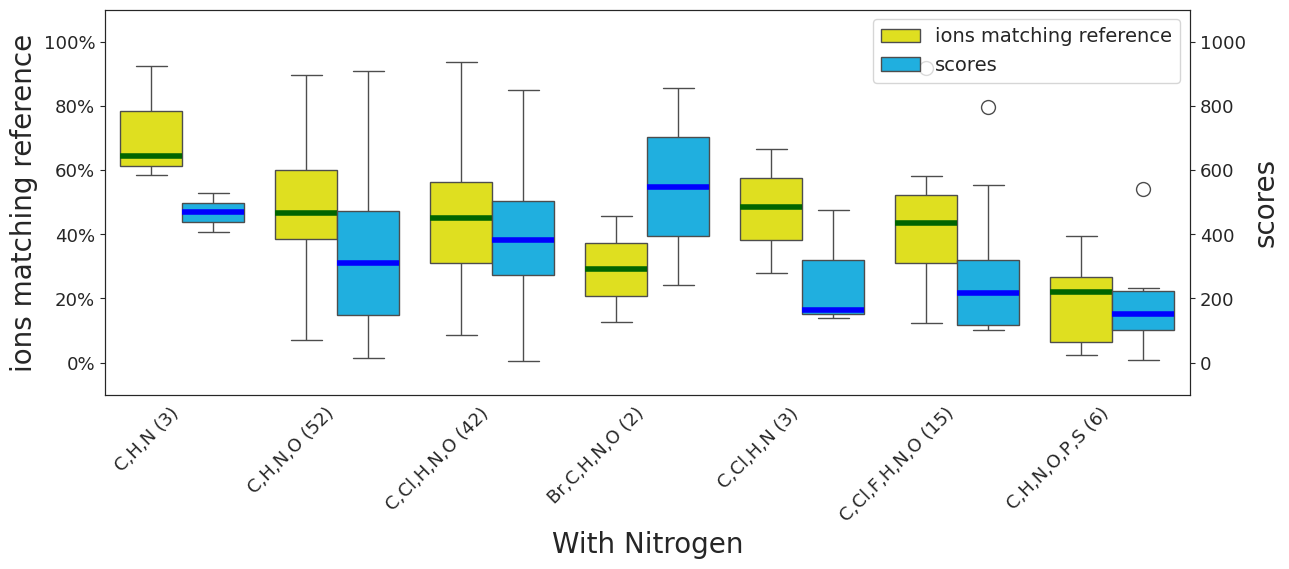

In [5]:
nitrogen_cols = ['C,H,N', 'C,H,N,O', 'C,Cl,H,N,O', 'Br,C,H,N,O', 'C,Cl,H,N', 'C,Cl,F,H,N,O', 'C,H,N,O,P,S']
mdf_comp_nitrogen = mdf_comp.loc[mdf_comp['composition'].isin(nitrogen_cols)]
mdf_comp_nitrogen.sort_index(axis=1, inplace=True)
create_plot(mdf_comp_nitrogen, "composition", "With Nitrogen", order=nitrogen_cols).show()

/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:228: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha='right')
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:228: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha='right')
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:228: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=45, ha='right')
/m2b/home/hechth/git/recetox/ei_spectra_predictions/analysis/Python_scripts/plotting.py:228: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

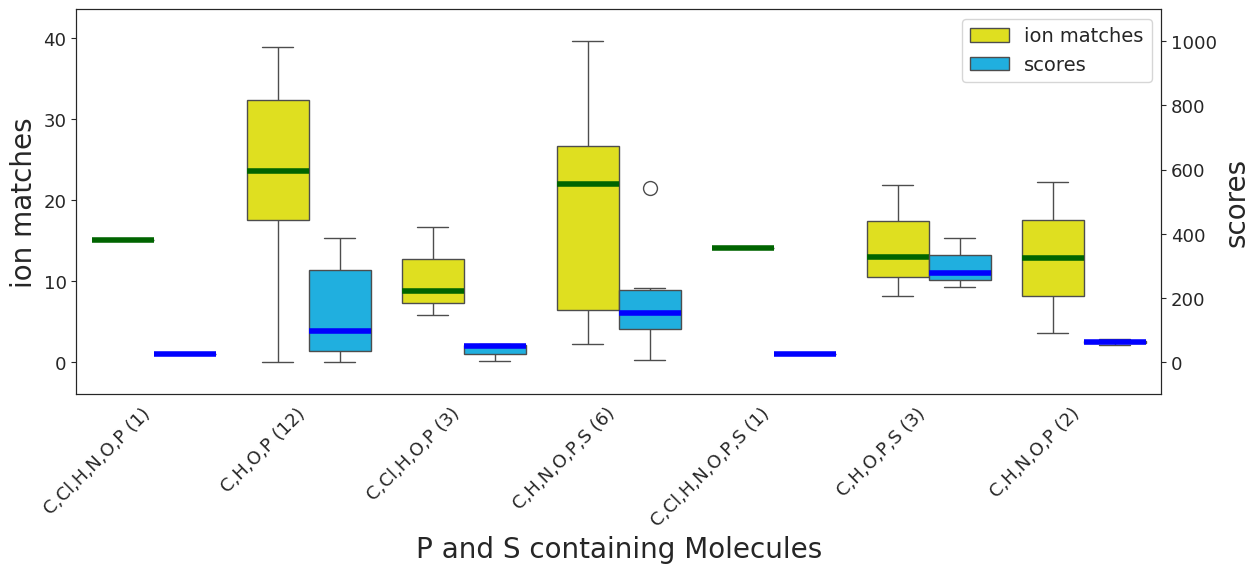

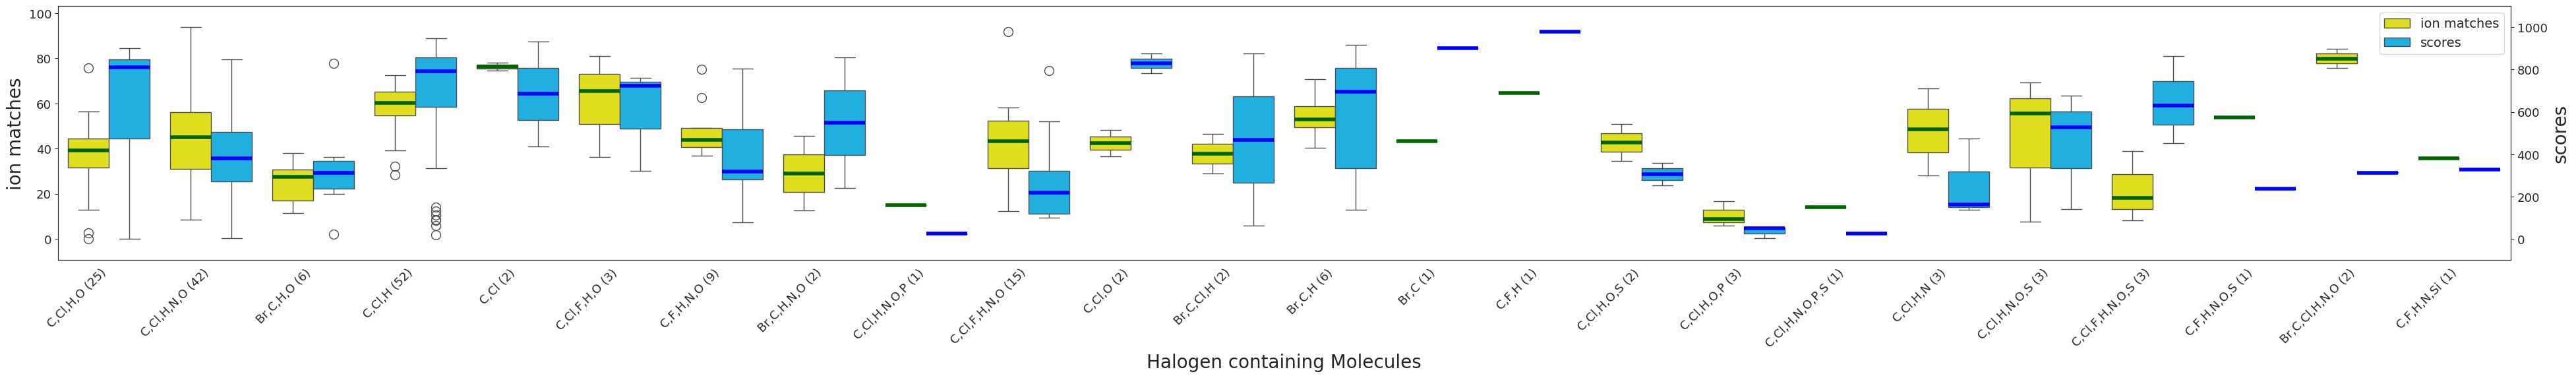

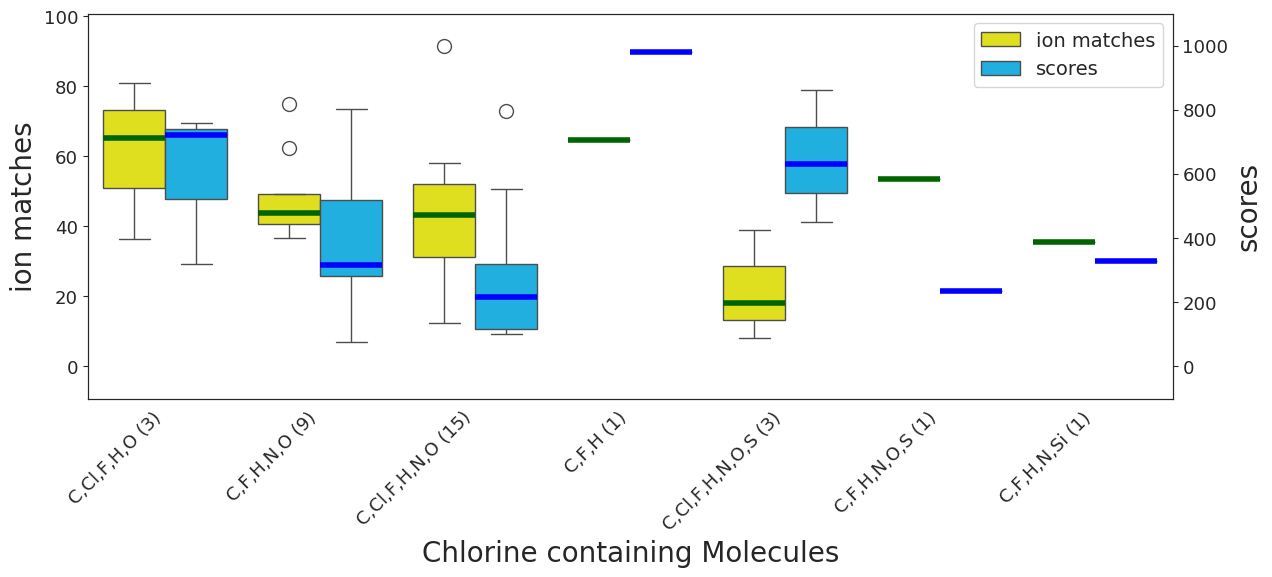

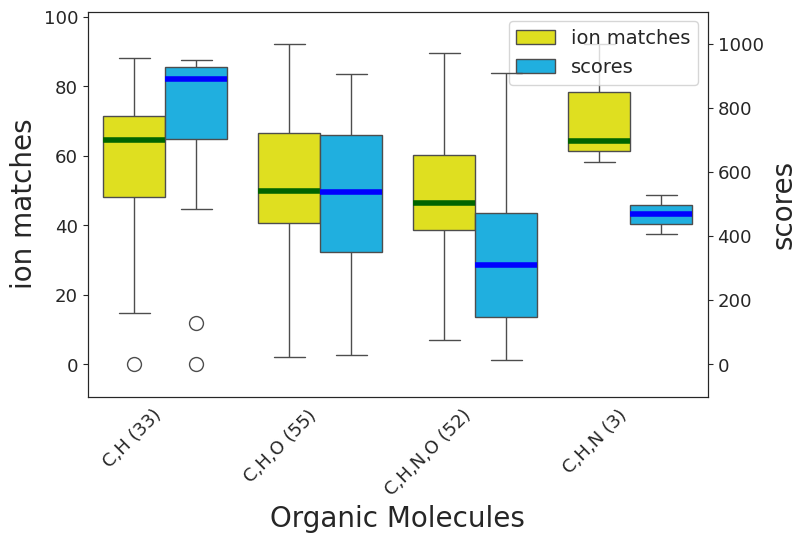

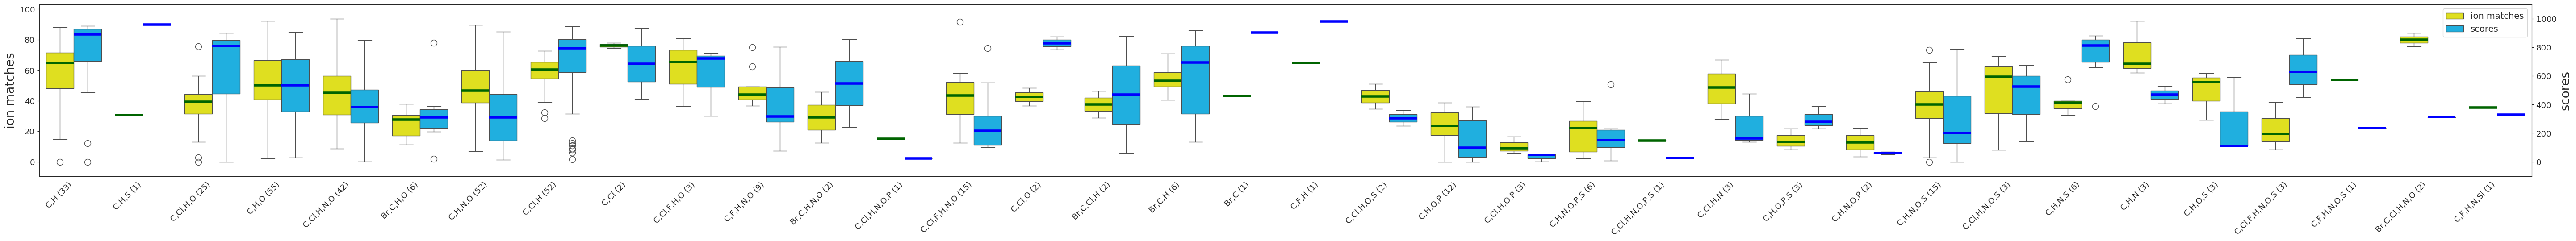

In [18]:
mdf_comp_ps = mdf_comp[mdf_comp['composition'].str.contains('P|S and not Si')]
mdf_comp_halogen = mdf_comp[mdf_comp['composition'].str.contains('Cl|Br|F|I')]
mdf_comp_chlorinated = mdf_comp[mdf_comp['composition'].str.contains('Cl and not Br|F|I')]
mdf_comp_organic = mdf_comp.loc[mdf_comp['composition'].isin(['C,H', 'C,H,O', 'C,H,N', 'C,H,N,O'])]

create_plot(mdf_comp_ps, "composition", "P and S containing Molecules", normalized_matches=False).show()
create_plot(mdf_comp_halogen, "composition", "Halogen containing Molecules", normalized_matches=False).show()
create_plot(mdf_comp_chlorinated, "composition", "Chlorine containing Molecules", normalized_matches=False).show()
create_plot(mdf_comp_organic, "composition", "Organic Molecules", normalized_matches=False).show()
create_plot(mdf_comp, "composition", normalized_matches=False).show()

In [ ]:
mdf_comp_chlorinated = mdf_comp[mdf_comp['composition'].str.contains('Cl') & ~mdf_comp['composition'].str.contains('Br|F|I|P|S|Si')]
create_plot(mdf_comp_chlorinated, "composition", "Chlorine containing Molecules", normalized_matches=False).show()

In [ ]:
mdf_comp_brominated = mdf_comp[mdf_comp['composition'].str.contains('Br') & ~mdf_comp['composition'].str.contains('Cl|F|I|P|S|Si')]
create_plot(mdf_comp_brominated, "composition", "Bromine containing Molecules", normalized_matches=False).show()